# Определение возраста покупателей

**Задача**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.<br>

Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Реальный возраст

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Вывод:** в датасете содержится 7591 фотография людей в возрасте от 1 года до 100 лет -- достаточно небольшой объем для реализации задачи. Чтобы увеличить количество данных, применим аугментацию (отобразим фото по горизонтали).

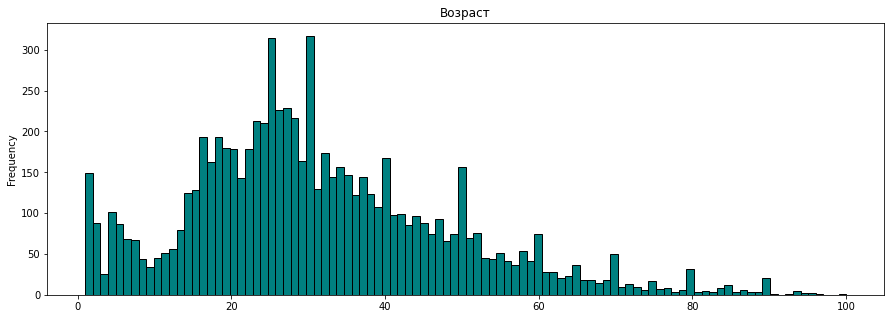

In [5]:
labels['real_age'].plot(title='Возраст',
                        kind='hist',
                        bins=100, 
                        color='teal', 
                        figsize=(15,5), 
                        ec="black");

In [6]:
# доля фотографий детей (до 18 лет) от общего числа фотографий
print(labels[labels['real_age']<18]['real_age'].count()/labels['real_age'].count())

0.19799762877091293


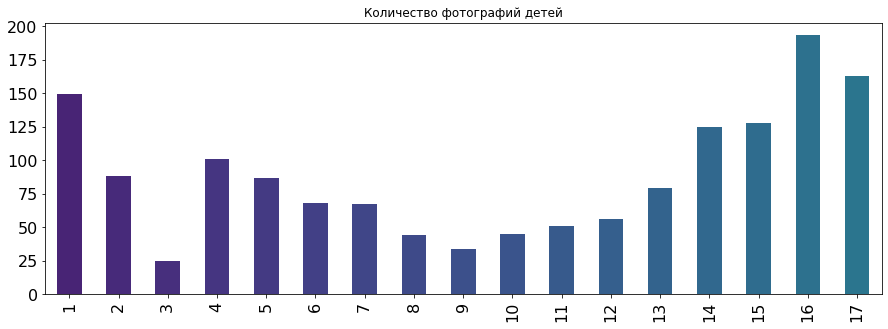

In [7]:
# распределение фотографий детей по возрастам
labels['real_age'][labels['real_age']<18].value_counts(sort=0).plot(title='Количество фотографий детей',
                                                                    fontsize=16,
                                                                    kind='bar',
                                                                    color=cm.viridis(np.linspace(.1,.8, 40)),
                                                                    figsize=(15,5));

**Вывод:**  
1. в датасете преобладают фотографии людей, возраст которых от 15 до 41 года. Доля фотографий детей до 18 лет составляет почти 20%, большая часть из них -- фото подростков 14-17 лет.<br>
2. на гистограмме заметны пики на возрасте 25, 30, 40, 50, 60, 70 80 лет. Возможно, это связано с тем, что действительный возраст человека на фото неизвестен, указан примерный. Для данной задачи эта неточность неважна, т.к. нам важно по фото определить несовершеннолетних.  

### Фотографии из датасета

In [8]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [9]:
path = '/datasets/faces/'
train_datagen_flow = load_train(path)

Found 5694 validated image filenames.


In [ ]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={}, Image size - {}'.format(target[i], features[i].shape), loc='center')    
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

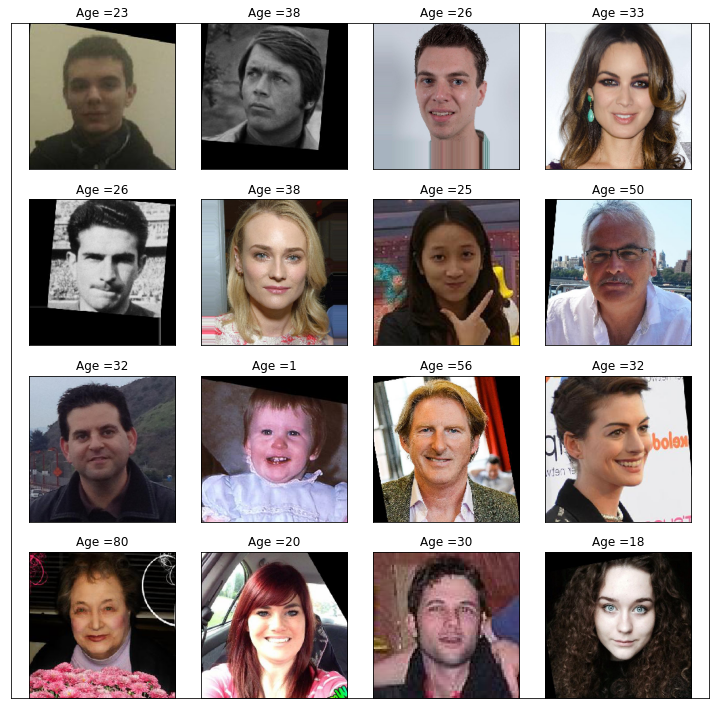

In [21]:
features, target = next(train_datagen_flow)

# выведем 16 изображений
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={}'.format(target[i], features[i].shape), loc='center')    
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** в датасете содержатся фото людей <br>
* разного пола, 
* снятые с разного ракурса,
* с разным выражением лиц,
* сделанные при различном освещении,
* цветные и черно-белые.<br>
Размер фото разный, т.к. заметна разница в качестве изображений (далее приведем фото к единому размеру).<br>
На фото сняты портреты, размеры лиц также примерно одинаковы. Изображения ориентированы правильно.

## Обучение модели

Код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

# результат вывода 

Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-09-10 12:00:13.770365: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-10 12:00:14.403289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 87s - loss: 202.2767 - mae: 10.7724 - val_loss: 380.8759 - val_mae: 14.5768
Epoch 2/10
356/356 - 51s - loss: 134.3165 - mae: 8.8205 - val_loss: 265.4360 - val_mae: 12.2304
Epoch 3/10
356/356 - 72s - loss: 110.3318 - mae: 8.0545 - val_loss: 140.8320 - val_mae: 9.1326
Epoch 4/10
356/356 - 71s - loss: 92.5139 - mae: 7.3321 - val_loss: 110.1815 - val_mae: 7.8690
Epoch 5/10
356/356 - 51s - loss: 83.0064 - mae: 6.9795 - val_loss: 119.5095 - val_mae: 8.2231
Epoch 6/10
356/356 - 69s - loss: 70.4377 - mae: 6.4256 - val_loss: 99.6711 - val_mae: 7.6716
Epoch 7/10
356/356 - 56s - loss: 56.2527 - mae: 5.7938 - val_loss: 105.5182 - val_mae: 7.6916
Epoch 8/10
356/356 - 49s - loss: 47.2025 - mae: 5.3447 - val_loss: 116.2867 - val_mae: 8.2160
Epoch 9/10
356/356 - 44s - loss: 41.5985 - mae: 4.9830 - val_loss: 114.5336 - val_mae: 7.8524
Epoch 10/10
356/356 - 42s - loss: 38.2471 - mae: 4.7941 - val_loss: 105.1640 - val_mae: 7.6551
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 105.1640 - mae: 7.6551
Test MAE: 7.6551

```

## Анализ обученной модели

Для решения задачи была использована сверточная нейронная сеть ResNet50, модель Sequential. Применен алгоритм оптимизации Adam с шагом (lr), равным 0,0005. Модель обучалась на 10 эпохах. К слою Dense применена функция активации  Relu.

Значение MAE на тестовой выборке 7.6551, что меньше значения, указанного в задании(8). Таким образом необходимая точность модели достигнута.<br>
Данная модель, скорее всего, хорошо справится с задачей по предложению товаров, которые могут заинтересовать покупателей этой возрастной группы. Однако, точности будет недостаточно для того, чтобы определить возраст при продаже алкогольных и табачных изделий.